In [4]:
from glob import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
sns.set_style("whitegrid")

In [6]:
def read_results(
    df: pd.DataFrame, path: str, data: str, model: str, 
    prompt_type: str, prompt_tokens: int, pretrained: str) -> pd.DataFrame:
    
    acc = json.load(open(path, 'r'))['best_acc']
    df_i = pd.DataFrame({
        'model'         : [model], 
        'data'          : [data], 
        'prompt_type'   : [prompt_type],
        'prompt_tokens' : [prompt_tokens],
        'pretrained'    : [pretrained],
        'acc'           : [acc*100]
    })
    
    return pd.concat([df, df_i], axis=0)

In [7]:
def load_results(
    data_list: list, model_list: list, model_map: dict, prompt_type: list, prompt_tokens: list) -> pd.DataFrame:
    
    df = pd.DataFrame()
    for d in data_list: 
        for m in model_list:
            pretrained = 'in21k' if 'in21k' in m else 'in1k'
            for t in prompt_type:
                exp_name = m
                if t == None:
                    df = read_results(
                        df            = df, 
                        path          = f'./saved_model/{d}/{exp_name}/best_results.json', 
                        data          = d,
                        model         = model_map[m],
                        prompt_type   = 'full',
                        prompt_tokens = 0,
                        pretrained    = pretrained
                    )
                else:
                    for p in prompt_tokens:
                        exp_name = f'{m}-{t}-n_prompts{p}'
                        df = read_results(
                            df            = df, 
                            path          = f'./saved_model/{d}/{exp_name}/best_results.json', 
                            data          = d,
                            model         = model_map[m],
                            prompt_type   = t,
                            prompt_tokens = p,
                            pretrained    = pretrained
                        )
        
    return df

# Performance

In [9]:
model_list = [
    'vit_small_patch16_224',
    'vit_small_patch16_224_in21k',
    'vit_base_patch16_224',
    'vit_base_patch16_224_in21k'
]
model_desc = [
    'ViT-S/16 w in1k',
    'ViT-S/16 w in21k',
    'VIT-B/16 w in1k',
    'ViT-B/16 w in21k'
]
model_map = dict(zip(model_list, model_desc))

data_list = ['CIFAR10','CIFAR100']
prompt_tokens = [5]
prompt_type = ['deep', 'shallow', None]

df = load_results(
    data_list     = data_list,
    model_list    = model_list,
    model_map     = model_map,
    prompt_type   = prompt_type,
    prompt_tokens = prompt_tokens
)

df.to_csv('./assets/table1.csv', index=False)

In [10]:
print(df.to_markdown())

|    | model            | data     | prompt_type   |   prompt_tokens | pretrained   |   acc |
|---:|:-----------------|:---------|:--------------|----------------:|:-------------|------:|
|  0 | ViT-S/16 w in1k  | CIFAR10  | deep          |               5 | in1k         | 93.47 |
|  0 | ViT-S/16 w in1k  | CIFAR10  | shallow       |               5 | in1k         | 92.49 |
|  0 | ViT-S/16 w in1k  | CIFAR10  | full          |               0 | in1k         | 96.44 |
|  0 | ViT-S/16 w in21k | CIFAR10  | deep          |               5 | in21k        | 92.48 |
|  0 | ViT-S/16 w in21k | CIFAR10  | shallow       |               5 | in21k        | 90.49 |
|  0 | ViT-S/16 w in21k | CIFAR10  | full          |               0 | in21k        | 96.55 |
|  0 | VIT-B/16 w in1k  | CIFAR10  | deep          |               5 | in1k         | 94.07 |
|  0 | VIT-B/16 w in1k  | CIFAR10  | shallow       |               5 | in1k         | 93.33 |
|  0 | VIT-B/16 w in1k  | CIFAR10  | full          |        

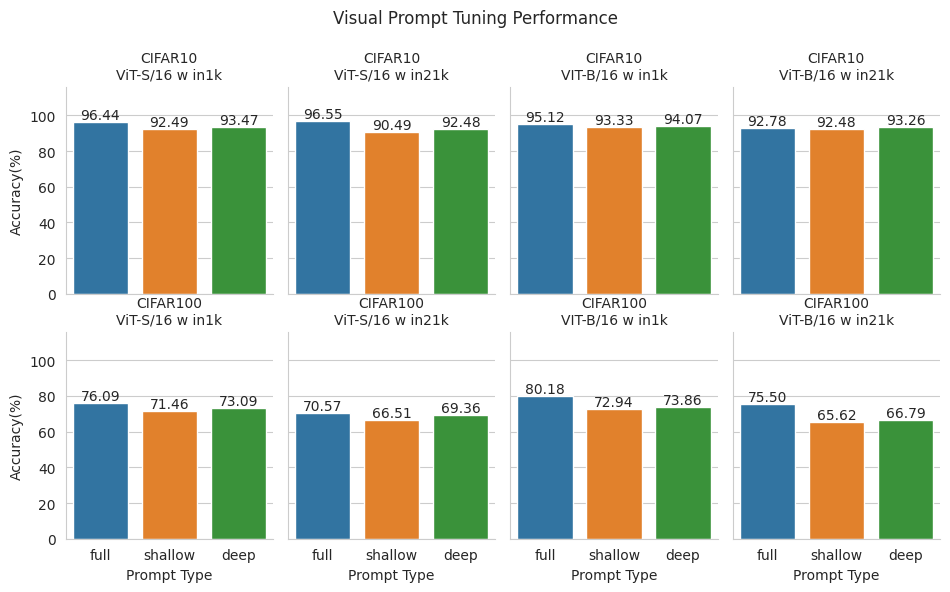

In [11]:
g = sns.catplot(
    x = 'prompt_type',
    y = 'acc',
    col = 'model',
    order = ['full','shallow','deep'],
    row = 'data',
    kind = 'bar',
    height=3, 
    aspect=.8,
    data = df
)
g.set_titles("{row_name}\n{col_name}")
g.set_ylabels("Accuracy(%)")
g.set_xlabels("Prompt Type")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visual Prompt Tuning Performance')

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height():.2f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

plt.savefig('./assets/figure1.jpg', dpi=100)

# Ablation: number of prompt tokens

In [22]:
model_list = [
    'vit_base_patch16_224'
]
model_desc = [
    'VIT-B/16 w in1k'
]
model_map = dict(zip(model_list, model_desc))

data_list = ['CIFAR10','CIFAR100']
prompt_tokens = [1,5,10]
prompt_type = ['deep', 'shallow']

df = load_results(
    data_list     = data_list,
    model_list    = model_list,
    model_map     = model_map,
    prompt_type   = prompt_type,
    prompt_tokens = prompt_tokens
)

df.to_csv('./assets/table2.csv', index=False)

In [23]:
print(df.to_markdown())

|    | model           | data     | prompt_type   |   prompt_tokens | pretrained   |   acc |
|---:|:----------------|:---------|:--------------|----------------:|:-------------|------:|
|  0 | VIT-B/16 w in1k | CIFAR10  | deep          |               1 | in1k         | 96.6  |
|  0 | VIT-B/16 w in1k | CIFAR10  | deep          |               5 | in1k         | 94.9  |
|  0 | VIT-B/16 w in1k | CIFAR10  | deep          |              10 | in1k         | 82    |
|  0 | VIT-B/16 w in1k | CIFAR10  | shallow       |               1 | in1k         | 42.39 |
|  0 | VIT-B/16 w in1k | CIFAR10  | shallow       |               5 | in1k         | 39.66 |
|  0 | VIT-B/16 w in1k | CIFAR10  | shallow       |              10 | in1k         | 32.83 |
|  0 | VIT-B/16 w in1k | CIFAR100 | deep          |               1 | in1k         | 76.25 |
|  0 | VIT-B/16 w in1k | CIFAR100 | deep          |               5 | in1k         | 75.11 |
|  0 | VIT-B/16 w in1k | CIFAR100 | deep          |              10 | 

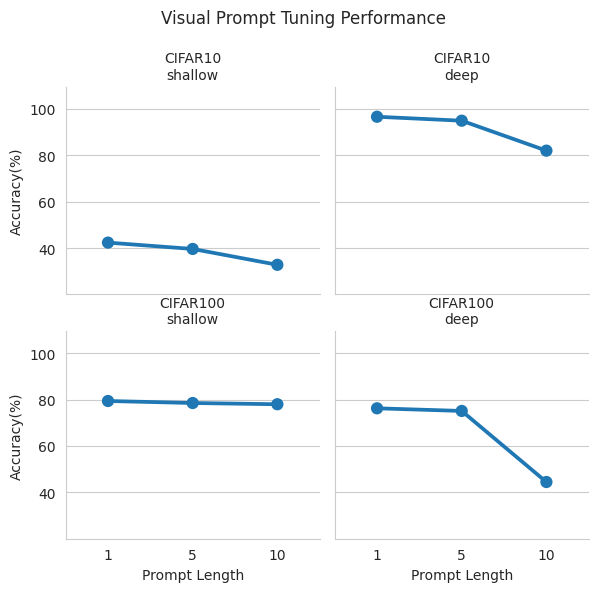

In [25]:
g = sns.catplot(
    x = 'prompt_tokens',
    y = 'acc',
    order = [1,5,10],
    col = 'prompt_type',
    col_order = ['shallow','deep'],
    row = 'data',
    kind = 'point',
    height=3, 
    aspect=1.,
    data = df
)
g.set_titles("{row_name}\n{col_name}")
g.set_ylabels("Accuracy(%)")
g.set_xlabels("Prompt Length")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Visual Prompt Tuning Performance')

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{v.get_height():.2f}' for v in c]
        ax.point_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

plt.savefig('./assets/figure2.jpg', dpi=100)

# Model Desc

In [1]:
from models import VPT
from timm import create_model

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
for t in [None, 'shallow', 'deep']:
    if t:
        model = VPT(
            modelname      = 'vit_small_patch16_224',
            num_classes    = 10,
            pretrained     = True,
            prompt_tokens  = 5,
            prompt_dropout = 0.0,
            prompt_type    = t
        )

        print(f'{t}: ',sum([p.numel() if p.requires_grad else 0 for p in model.parameters()]))
    else:
        model = create_model(
            model_name     = 'vit_small_patch16_224',
            num_classes    = 10,
            pretrained     = True,
        )
        print('full: ',sum([p.numel() if p.requires_grad else 0 for p in model.parameters()]))        

full:  21669514
shallow:  5770
deep:  26890


In [3]:
for t in [None, 'shallow', 'deep']:
    if t:
        model = VPT(
            modelname      = 'vit_base_patch16_224',
            num_classes    = 10,
            pretrained     = True,
            prompt_tokens  = 5,
            prompt_dropout = 0.0,
            prompt_type    = t
        )

        print(f'{t}: ',sum([p.numel() if p.requires_grad else 0 for p in model.parameters()]))
    else:
        model = create_model(
            model_name     = 'vit_base_patch16_224',
            num_classes    = 10,
            pretrained     = True,
        )
        print('full: ',sum([p.numel() if p.requires_grad else 0 for p in model.parameters()]))        

full:  85806346
shallow:  11530
deep:  53770
